In [132]:
import matplotlib.pyplot as plt
import pandas as pd
from numpy import linalg as LA
from scipy.sparse import csr_matrix
from sklearn import decomposition, metrics, preprocessing
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor, 
                              GradientBoostingClassifier, StackingClassifier)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import (accuracy_score, auc, average_precision_score,
                             classification_report, confusion_matrix, log_loss,
                             make_scorer, plot_precision_recall_curve,
                             plot_roc_curve, precision_recall_curve,
                             roc_auc_score, roc_curve, plot_confusion_matrix)
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
%matplotlib inline

In [22]:
def model_performance_evaluation(y_test, y_pred):
    print("=== Confusion Matrix ===")
    print(confusion_matrix(y_test, y_pred))
    print('\n')
    print("=== Classification Report ===")
    print(classification_report(y_test, y_pred))
    print('\n')

In [2]:
relations_features_df = pd.read_csv("../data/relations_features3.csv", delimiter = '\t', index_col="src")

/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [63]:
relations_df = pd.read_csv("../data/relations_features.csv", delimiter="\t", index_col="src")

In [64]:
relations_df.head()

,dt_1,dt_2,dt_3,dt_4,dt_5,dt_6,dt_7,dout_1,dout_2,dout_3,dout_4,dout_5,dout_6,dout_7,u_neigh,n_bidir
src,,,,,,,,,,,,,,,,
1,0,0,40,61,53,121,0,0,0,22,22,32,14,0,166,24
2,1,0,28,41,65,159,0,0,0,0,12,3,44,0,189,12
3,0,9,29,8,6,5,0,0,4,24,6,0,0,0,34,3
4,0,0,5,9,15,7,0,0,0,1,6,6,0,0,21,5
5,0,0,5,11,11,11,0,0,0,4,6,5,1,0,23,7


In [3]:
userdata_df = pd.read_csv("../data/usersdata.csv", delimiter = '\t', names = ["ID", "Gender", "Time", "Age", "Label"], index_col = "ID")

In [4]:
userdata_df.head()

,Gender,Time,Age,Label
ID,,,,
1,M,0.9000,30,0
2,F,1.0000,20,0
3,M,0.1375,30,0
4,M,0.3875,20,0
5,M,0.0125,20,0


##  data

In [65]:
df = userdata_df.merge(relations_df, how='inner', left_index=True, right_index=True)

In [66]:
df = pd.concat([df, pd.get_dummies(df['Gender'], prefix='Gender', drop_first=True)], axis=1).drop(['Gender'], axis=1)

In [67]:
# Assign weights to sample equal number of Spam and Ham
df["inv_value_count"] = 0
df["inv_value_count"][df.Label == 1] = 1/df["Label"].value_counts()[1]
df["inv_value_count"][df.Label == 0] = 1/df["Label"].value_counts()[0]

/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [123]:
# to sample equal number of spam/ham we add weight with inv_value_count columns
df_sample = df.sample(n = 200000, weights = 'inv_value_count').drop(["inv_value_count"], axis=1)

In [124]:
graph_features_subset = df_sample.drop(["Gender_M", "Time", "Age"], axis=1)

In [90]:
graph_features_subset.head()

,Label,dt_1,dt_2,dt_3,dt_4,dt_5,dt_6,dt_7,dout_1,dout_2,dout_3,dout_4,dout_5,dout_6,dout_7,u_neigh,n_bidir
5346371,1,1,2,27,45,45,129,0,0,0,5,18,0,0,0,185,10
4770515,0,0,0,39,0,100,198,0,0,0,8,0,0,134,0,276,36
3672277,1,0,0,115,146,12,13,0,0,0,107,114,6,0,0,124,20
2710906,1,0,1,129,597,90,222,0,0,1,52,319,35,77,0,325,66
1270870,0,0,0,1,0,16,23,0,0,0,0,0,11,12,0,39,0


In [125]:
X, y = graph_features_subset.drop("Label", axis=1), graph_features_subset[["Label"]]
X, y = X.values, y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Random Forest

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   33.8s finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/model_selection/_search.py:741: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.7421500000000001
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'bootstrap': True, 'max_depth': 15, 'n_estimators': 40}


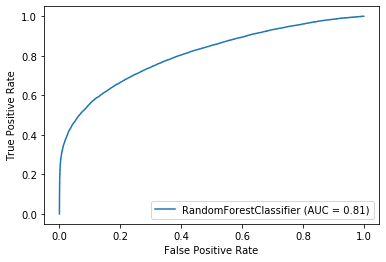

In [126]:
grid_params_rf = {
    'bootstrap': [True],
    'max_depth': [5, 10, 15],
    'n_estimators': [10, 20, 40]
}
gs_rf = GridSearchCV(RandomForestClassifier(), grid_params_rf, verbose = 1, cv = 4, n_jobs = -1)
gs_results_rf = gs_rf.fit(X_train, y_train)
print(gs_results_rf.best_score_)
print(gs_results_rf.best_estimator_)
print(gs_results_rf.best_params_)

from sklearn.metrics import plot_roc_curve
rf_disp = plot_roc_curve(gs_results_rf.best_estimator_, X_test, y_test)
plt.show()

In [78]:
rf_best_params_ = {'bootstrap': True, 'max_depth': 5, 'n_estimators': 20}
rf = RandomForestClassifier(**rf_best_params_)
rf.fit(X_train,y_train)
rf_predict = rf.predict(X_test)
model_performance_evaluation(y_test, rf_predict)

/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


=== Confusion Matrix ===
[[4123  871]
 [2248 2758]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.65      0.83      0.73      4994
           1       0.76      0.55      0.64      5006

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.68     10000
weighted avg       0.70      0.69      0.68     10000





In [79]:
rf.score(X_train, y_train)

0.699075

## XGBoost

In [80]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

grid_params_xgb = {
    'max_depth': [5, 10],
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.01, 0.05]
}

gs_xgb = GridSearchCV(xgb, grid_params_xgb, verbose = 1, cv = 4, n_jobs = -1)
gs_results_xgb = gs_xgb.fit(X_train, y_train)

print(gs_results_xgb.best_score_)
print(gs_results_xgb.best_estimator_)
print(gs_results_xgb.best_params_)

xgb_disp = plot_roc_curve(gs_results_xgb.best_estimator_, X_test, y_test)
plt.show()

# Adding user data

In [127]:
X, y = df_sample.drop("Label", axis=1), df_sample[["Label"]]
X, y = X.values, y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Random Forest

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.1min finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/model_selection/_search.py:741: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.7792812499999999
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=85,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'bootstrap': True, 'max_depth': 20, 'n_estimators': 85}


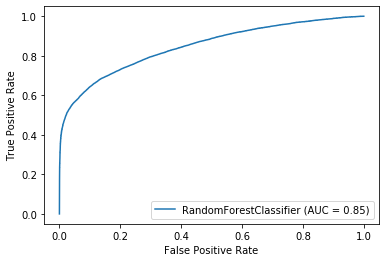

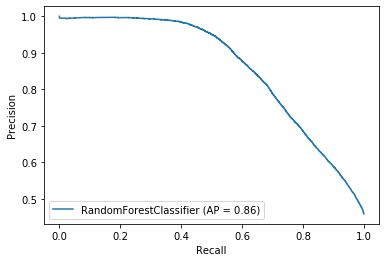

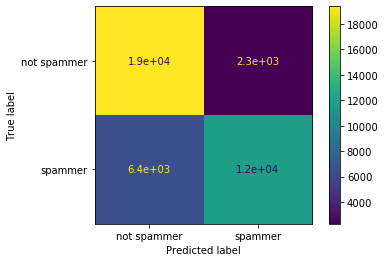

In [134]:
grid_params_rf = {
    'bootstrap': [True],
    'max_depth': [10, 15, 20],
    'n_estimators': [60, 80, 85]
}
gs_rf = GridSearchCV(RandomForestClassifier(), grid_params_rf, verbose = 1, cv = 4, n_jobs = -1)
gs_results_rf = gs_rf.fit(X_train, y_train)
print(gs_results_rf.best_score_)
print(gs_results_rf.best_estimator_)
print(gs_results_rf.best_params_)
from sklearn.metrics import plot_roc_curve
rf_roc = plot_roc_curve(gs_results_rf.best_estimator_, X_test, y_test)
rf_precision_recall = plot_precision_recall_curve(gs_results_rf.best_estimator_, X_test, y_test)
rf_confusion_matrix = plot_confusion_matrix(gs_results_rf.best_estimator_, X_test, y_test,
                                           display_labels=["not spammer", "spammer"])
plt.show()

## XGBoost

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  1.4min finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7718875000000001
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=120, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 120}


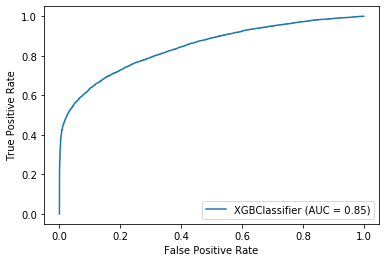

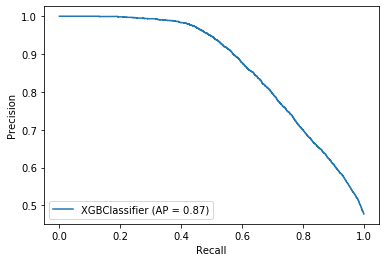

In [120]:
xgb = XGBClassifier(
    objective= 'binary:logistic',
    seed=42
)

grid_params_xgb = {
    'max_depth': [5, 7],
    'n_estimators': [100, 120],
    'learning_rate': [0.1, 0.05]
}

gs_xgb = GridSearchCV(xgb, grid_params_xgb, verbose = 1, cv = 4, n_jobs = -1)
gs_results_xgb = gs_xgb.fit(X_train, y_train)

print(gs_results_xgb.best_score_)
print(gs_results_xgb.best_estimator_)
print(gs_results_xgb.best_params_)

xgb_roc = plot_roc_curve(gs_results_xgb.best_estimator_, X_test, y_test)
xgb_precision_recall = plot_precision_recall_curve(gs_results_xgb.best_estimator_, X_test, y_test)
plt.show()

## Gradient Boosting Classifier

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  5.9min finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.766775
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=7,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100}


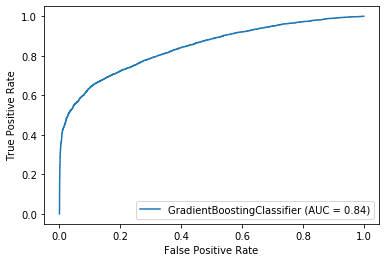

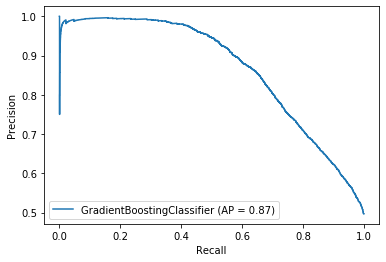

In [105]:
grid_params_gb = {
    'max_depth': [7, 9, 11],
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.01]
}
gs_gb = GridSearchCV(GradientBoostingClassifier(), grid_params_gb, verbose = 1, cv = 4, n_jobs = -1)
gs_results_gb = gs_gb.fit(X_train, y_train)
print(gs_results_gb.best_score_)
print(gs_results_gb.best_estimator_)
print(gs_results_gb.best_params_)
rf_roc = plot_roc_curve(gs_results_gb.best_estimator_, X_test, y_test)
rf_precision_recall = plot_precision_recall_curve(gs_results_gb.best_estimator_, X_test, y_test)
plt.show()

In [ ]:
## Logistic Classification

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.0s finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:937: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7132999999999999
RidgeClassifier(alpha=0.1, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)
{'alpha': 0.1}


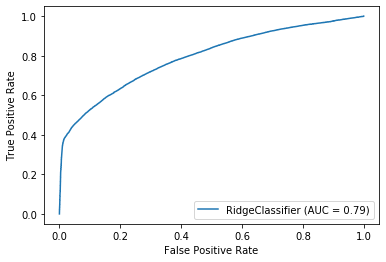

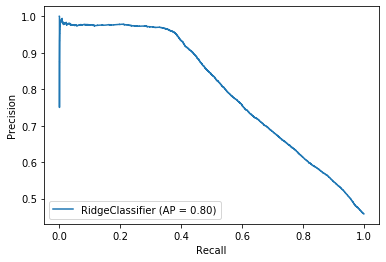

In [129]:
grid_params_rc = {
    "alpha": [1.0, 0.1, 0.05, 0.5]
}
gs_rc = GridSearchCV(RidgeClassifier(), grid_params_rc, verbose = 1, cv = 4, n_jobs = -1)
gs_results_rc = gs_rc.fit(X_train, y_train)
print(gs_results_rc.best_score_)
print(gs_results_rc.best_estimator_)
print(gs_results_rc.best_params_)
rc_roc = plot_roc_curve(gs_results_rc.best_estimator_, X_test, y_test)
rc_precision_recall = plot_precision_recall_curve(gs_results_rc.best_estimator_, X_test, y_test)
plt.show()

## Stacking

/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


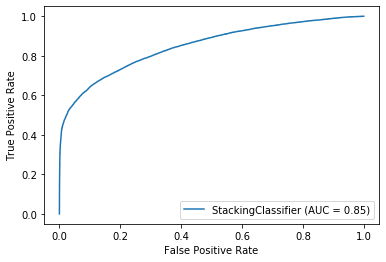

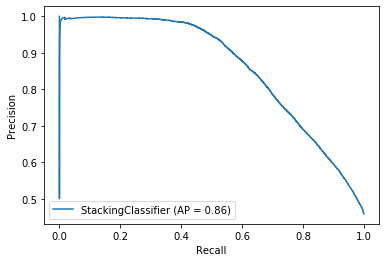

In [131]:
estimators = [('rf', gs_results_rf.best_estimator_),
             ('xgb', gs_results_xgb.best_estimator_),
             ('gb', gs_results_gb.best_estimator_),
             ('rc', gs_results_rc.best_estimator_),]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1)
clf.fit(X_train, y_train)
rf_roc = plot_roc_curve(clf, X_test, y_test)
rf_precision_recall = plot_precision_recall_curve(clf, X_test, y_test)
plt.show()